In [2]:
import sys
sys.path.append("../src/")

import nussl
from nussl.datasets import transforms as nussl_tfm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

import models

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
INFO:root:

------------------------------ 
- Starting to Fit Agent
------------------------------- 




In [191]:
# rnn separator
rnn_config = {
    'bidirectional': True,
    'dropout': 0.3,
    'filter_length': 256,
    'hidden_size': 50,
    'hop_length': 64,
    'mask_activation': ['softmax'],
    'mask_complex': False,
    'mix_key': 'mix_audio',
    'normalization_class': 'BatchNorm',
    'num_audio_channels': 1,
    'num_filters': 256,
    'num_layers': 1,
    'num_sources': 2,
    'rnn_type': 'lstm',
    'window_type': 'sqrt_hann',
}

rnn_config = nussl.ml.networks.builders.build_recurrent_end_to_end(**rnn_config)

rnn = models.RnnSeparator(rnn_config)

/Users/grantgasser/anaconda3/envs/otoworld-test/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [192]:
class PreTrainDataset(Dataset):
    def __init__(self):
        # load the two sources
        source1 = nussl.AudioSignal('../sounds/phone/cellphone_ringing.wav')
        source2 = nussl.AudioSignal('../sounds/siren/siren.wav')
        
        # preprocess 
        source2.to_mono(overwrite=True)
        source1.truncate_seconds(source2.signal_duration)
        mix = source1 + source2
        sample = {'mix': mix, 'sources': {'source1': source1, 'source2': source2}}
        
        # transform
        self.transform = nussl_tfm.Compose([
            nussl_tfm.GetAudio(),
            nussl_tfm.ToSeparationModel()
        ])
        
        sample = self.transform(sample)
        
        # train on many of the same examples
        self.items = [sample] * 300
    
    def __getitem__(self, index):
        return self.items[index]
    
    def __len__(self):
        return len(self.items)

In [193]:
dataset = PreTrainDataset()

In [194]:
dataloader = DataLoader(dataset, batch_size=10)

In [195]:
loss_fn = nussl.ml.train.loss.SISDRLoss()
optimizer = optim.Adam(rnn.parameters(), lr=.001)

In [196]:
losses = []
for i, data in enumerate(dataloader):    
    output = rnn(data)
    
    # preds vs. ground truth
    loss = loss_fn(output['audio'], data['source_audio'])
    print(loss)
    losses.append(loss)
    
    # backprop
    loss.backward()
    optimizer.step()

tensor(-1.4873, grad_fn=<NegBackward>)
tensor(-3.2339, grad_fn=<NegBackward>)
tensor(-4.5363, grad_fn=<NegBackward>)
tensor(-5.5227, grad_fn=<NegBackward>)
tensor(-6.3292, grad_fn=<NegBackward>)
tensor(-7.0502, grad_fn=<NegBackward>)
tensor(-7.7044, grad_fn=<NegBackward>)
tensor(-8.2867, grad_fn=<NegBackward>)
tensor(-8.8094, grad_fn=<NegBackward>)
tensor(-9.2838, grad_fn=<NegBackward>)
tensor(-9.7201, grad_fn=<NegBackward>)
tensor(-10.1191, grad_fn=<NegBackward>)
tensor(-10.4735, grad_fn=<NegBackward>)
tensor(-10.7760, grad_fn=<NegBackward>)
tensor(-11.0221, grad_fn=<NegBackward>)
tensor(-11.2172, grad_fn=<NegBackward>)
tensor(-11.3686, grad_fn=<NegBackward>)
tensor(-11.4837, grad_fn=<NegBackward>)
tensor(-11.5702, grad_fn=<NegBackward>)
tensor(-11.6359, grad_fn=<NegBackward>)
tensor(-11.6841, grad_fn=<NegBackward>)
tensor(-11.7202, grad_fn=<NegBackward>)
tensor(-11.7455, grad_fn=<NegBackward>)
tensor(-11.7625, grad_fn=<NegBackward>)
tensor(-11.7739, grad_fn=<NegBackward>)
tensor(-11.

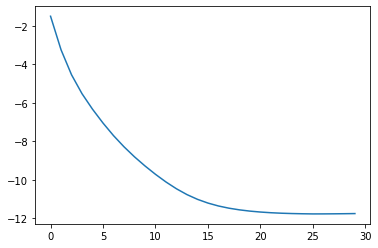

In [197]:
plt.plot(losses)

### Evaluate

In [198]:
# get sources and mix
source1 = nussl.AudioSignal('../sounds/phone/cellphone_ringing.wav')
source2 = nussl.AudioSignal('../sounds/siren/siren.wav')

source2.to_mono(overwrite=True)
source1.truncate_seconds(source2.signal_duration)
mix = source1 + source2

print(mix)
mix.embed_audio(display=False)

AudioSignal (unlabeled): 4.315 sec @ ../sounds/phone/cellphone_ringing.wav, 44100 Hz, 1 ch.


In [199]:
def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-80, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)


 SeparationModel(
  (layers): ModuleDict(
    (audio): STFT()
    (concatenate): Concatenate()
    (estimates): Mask()
    (expand): Expand()
    (log_spectrogram): AmplitudeToDB()
    (mask): Embedding(
      (linear): Linear(in_features=100, out_features=258, bias=True)
    )
    (normalization): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (recurrent_stack): RecurrentStack(
      (rnn): LSTM(129, 50, batch_first=True, dropout=0.3, bidirectional=True)
    )
    (split): Split()
  )
)
Number of parameters: 98460

 STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann')

 [<nussl.core.audio_signal.AudioSignal object at 0x7fb2c1e42910>, <nussl.core.audio_signal.AudioSignal object at 0x7fb2e6d71d60>]


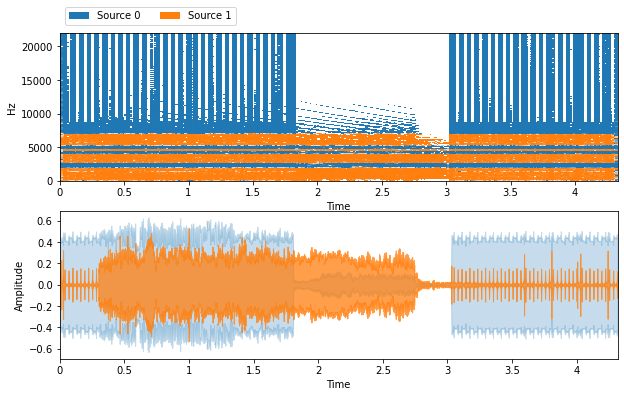


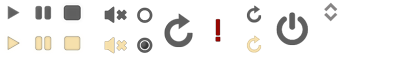
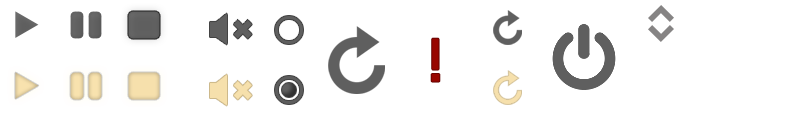
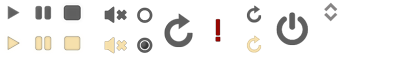

In [200]:
# in case we need to load saved model
# rnn = models.RnnSeparator(rnn_config)
# model_dict = torch.load(save_path)
# rnn.rnn_model = nussl.ml.SeparationModel(model_dict['config'])
# rnn.rnn_model.load_state_dict(model_dict['state_dict'])

separator = nussl.separation.deep.DeepAudioEstimation(mix, model_path=None)
separator.model = rnn.rnn_model

print('\n', separator.model)

separator.transform = nussl_tfm.Compose([
    nussl_tfm.GetAudio(),
    nussl_tfm.ToSeparationModel()
])

separator.device = 'cpu'

print('\n', mix.stft_params)
separator.metadata = {
    'sample_rate': 44100,
    'stft_params': mix.stft_params,
    'num_channels': 1
}

estimates = separator()
print('\n', estimates)

# passing "mix" results in a error
ibm = nussl.separation.benchmark.IdealBinaryMask(mix, estimates)
estimates = ibm()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

In [201]:
estimates['Source 0'].embed_audio(display=False)

In [202]:
estimates['Source 1'].embed_audio(display=False)